# "A neural network for elastography (part 1)"
> "Let's train a neural network to solve a typical problem encountered in elastography"

- toc: true 
- badges: true
- comments: false
- categories: [elastography]
- author: Lucas Almeida Rocha

## Introduction

[Elastography](https://en.wikipedia.org/wiki/Elastography) is a medical imaging that informs us about the stiffness of a soft tissue. This information is relevant because many diseases form harder tissues. For instance, tumours, thrombus and diseased liver tissue are usually harder than their surrounding tissues.

The basic idea is to:
1. apply some deformation in the tissue. It can be done manually, with a probe, or we could even use our own heartbeat.
2. measure how much the tissue moves. This is the displacement field and can be measured with ultrasound, magnetic resonance imaging (MRI), etc.
3. calculate the stiffness of the tissue or some other elastic property.


The third step is called *Inverse Problem*. It receives this name, because the usual problem is to determine the displacement field from a known stiffness (this would be the *Direct Problem*) and the inverse problem does the opposite. There are mainly two ways to solve the inverse problem:
- Directly: we just solve the governing equations of the problem. This approach is relatively fast and simple, but it suffers from the noise present in the displacement field measured.
- Iteratively: we keep updating the stiffness until we find one such as, when we solve the direct problem, we obtain a displacement field very similar to the measured one. This approach is in theory more robust to noise, but it is much slower and more complicate to use in practice, because it involves some parameter tweaking.

If you want to know more about elastography and these two approaches, check out [Fovargue, Nordsletten and Sinkus (2018)](https://dx.doi.org/10.1002%2Fnbm.3935).

We will solve this inverse problem in a different way. We will use a neural network! Recently, authors seem to be giving some attention to this approach. See for instance [Kibria and Rivaz (2018)](https://arxiv.org/abs/1805.07493) and [Solamen, Shi and Amoh (2018)](https://arxiv.org/abs/1812.00441). The main advantage is that this approach is fast (after the neural network is trained, of course) and robust to noise. A major limitation is the necessity of training data, but *transfer learning* could be a way to overcome it. Models could be pre-trained with synthetic data and then fine-tuned with a small number of real clinical data samples.

Creating synthetic data takes some time, but lucky for us, [Lejeune (2020)](https://doi.org/10.1016/j.eml.2020.100659) did it. She created the [Mechanical MNIST](https://open.bu.edu/handle/2144/39371), which is a collection of datasets of finite element simulations, where heterogeneous blocks composed of Neo-Hookean material are subjected to some kind of loading. It can be uniaxial extension, confined compression, shear, etc. The blocks are essentially a soft material with a hard inclusion, whose shape is a handwritten digit from the famous [MNIST Dataset](http://www.pymvpa.org/datadb/mnist.html). The value of each pixel was converted to a Young modulus, which was used in the finite element simulations to obtain the displacement field. Young modulus is a measure of stiffness of a solid material, so let's call it just "stiffness".

Enough talk, let's code!

We will make our neural network with [PyTorch](https://pytorch.org/) and [fastai](https://www.fast.ai/). PyTorch is a widely used Python library developed by Facebook for machine and deep learning. Fastai is a deep learning library built on Pytorch. It provides high-level and low-level components that simplifies many aspects of a deep learning project.

>Note: I won't explain the details about neural networks, PyTorch or fastai. If you want to learn more about them, I recommend the [Deep Learning Specialization by deeplearning.ai on Coursera](https://www.coursera.org/specializations/deep-learning) for the first and the [fastai MOOC](https://course.fast.ai/) for the last two.

If you're using Colab, you need to install these libraries. They are not installed by default.

In [ ]:
!pip install torch
!pip install fastai
!pip install fastai --upgrade -q

Now we download and unzip the data that we will use for the training. We will use only the fifth step of the uniaxial extension from [Mechanical MNIST](https://open.bu.edu/handle/2144/39371).

The data contain the displacement field and handwritten digits from [MNIST Dataset](http://www.pymvpa.org/datadb/mnist.html), which represents the soft background material and the inclusion.

In [ ]:
import os.path
if not os.path.exists('MNIST_input_files.zip'):
  !wget https://open.bu.edu/bitstream/handle/2144/38693/MNIST_input_files.zip

if not os.path.exists('FEA_displacement_results_step5.zip'):
  !wget https://open.bu.edu/bitstream/handle/2144/38693/FEA_displacement_results_step5.zip

!unzip -n "MNIST_input_files.zip" -d "."                        # replace "-n" with "-o" if you wish to overwrite existing files
!unzip -n "FEA_displacement_results_step5.zip" -d "uniaxial/"

Let's import some libraries.

In [ ]:
from pathlib import Path
import pandas as pd
import torch
from fastai.vision.all import *

## Data preparation

We load the data from the text files to pytorch tensors. Don't worry, the data is small.

In [ ]:
df = pd.read_csv('MNIST_input_files/mnist_img_train.txt', sep=' ', header=None)
imgs_train = torch.tensor(df.values)

df = pd.read_csv('MNIST_input_files/mnist_img_test.txt', sep=' ', header=None)
imgs_valid = torch.tensor(df.values)

imgs_train.shape, imgs_valid.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [ ]:
df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispx_train_step5.txt', sep=' ', header=None)
ux5s_train = torch.tensor(df.values)

df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispy_train_step5.txt', sep=' ', header=None)
uy5s_train = torch.tensor(df.values)

df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispx_test_step5.txt', sep=' ', header=None)
ux5s_valid = torch.tensor(df.values)

df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispy_test_step5.txt', sep=' ', header=None)
uy5s_valid = torch.tensor(df.values)


ux5s_train.shape, uy5s_train.shape, ux5s_valid.shape, uy5s_valid.shape

(torch.Size([60000, 784]),
 torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([10000, 784]))

We reshape the tensors, so we can show it as regular images with one channel.

In [ ]:
ux5s_train = torch.reshape(ux5s_train, (-1,1,28,28))
uy5s_train = torch.reshape(uy5s_train, (-1,1,28,28))
ux5s_valid = torch.reshape(ux5s_valid, (-1,1,28,28))
uy5s_valid = torch.reshape(uy5s_valid, (-1,1,28,28))

imgs_train = torch.reshape(imgs_train, (-1,1,28,28))
imgs_valid = torch.reshape(imgs_valid, (-1,1,28,28))

ux5s_train.shape, uy5s_train.shape, ux5s_valid.shape, uy5s_valid.shape, imgs_train.shape, imgs_valid.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]))

Let's take a look in our data.

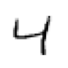

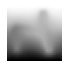

In [ ]:
show_image(imgs_train[2], cmap='Greys')
show_image(uy5s_train[2], cmap='Greys')

The displacement field seems inverted, let's fix it.

In [ ]:
ux5s_train = torch.flip(ux5s_train, dims=[1,2])
uy5s_train = torch.flip(uy5s_train, dims=[1,2])
ux5s_valid = torch.flip(ux5s_valid, dims=[1,2])
uy5s_valid = torch.flip(uy5s_valid, dims=[1,2])

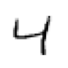

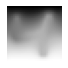

In [ ]:
show_image(imgs_train[2], cmap='Greys')
show_image(uy5s_train[2], cmap='Greys')

Ok, much better.

Now let's convert the pixel values (0-255) to stiffness values (0.01-1). This step is not really necessary, our network could predict directly the pixels values and not stiffness.

The original formula from [Lejeune (2020)](https://doi.org/10.1016/j.eml.2020.100659) is
$$
\mathrm{stiffness} = \frac{\mathrm{pixel}}{255}\, 99 + 1,
$$
but we include a division by 100, because it is convenient for visualization purposes. Again, we could skip this conversion.

In [ ]:
imgs_train = (imgs_train / 255.) * 99. + 1.
imgs_valid = (imgs_valid / 255.) * 99. + 1.

imgs_train = imgs_train / 100.
imgs_valid = imgs_valid / 100.

In [ ]:
imgs_train.min(), imgs_valid.min(), imgs_train.max(), imgs_valid.max()

(tensor(0.0100), tensor(0.0100), tensor(1.), tensor(1.))

Let's merge the horizontal and vertical displacements into one tensor, so that each component of the displacement field is in a separate channel.

In [ ]:
us_train = torch.cat([ux5s_train, uy5s_train], dim=1)
us_valid = torch.cat([ux5s_valid, uy5s_valid], dim=1)

us_train.shape, us_valid.shape

(torch.Size([60000, 2, 28, 28]), torch.Size([10000, 2, 28, 28]))

We do some cleaning.

In [ ]:
del ux5s_train; del uy5s_train; del ux5s_valid; del uy5s_valid

Now, we create fastai *DataLoaders* from a low-level API.

The first step is to create our *Transform*. Fastai Transforms are basically classes which modify the dataset, when the batch is being prepared.

Our Transform is simple, it receives a integer *i* and returns a tuple *(x,y)*, where *x* and *y* are the *i*-th element of `us_train` and `imgs_train`, respectively. Our Transform also normalizes these elements.

In [ ]:
class GetNormalizedData(Transform):
  def __init__(self, us, imgs, mean, std):
    self.us, self.imgs = us, imgs
    self.mean, self.std = mean, std

  def encodes(self, i):
    us_normalized = torch.true_divide((self.us[i] - self.mean.view(2,1,1)), self.std.view(2,1,1))
    return (us_normalized.float(), self.imgs[i].float())

We calculate the mean and the standard deviation of our data.

In [ ]:
us_mean = torch.mean(us_train, dim=[0,2,3])
us_std = torch.std(us_train, dim=[0,2,3])

We create a *TfmdLists* (*Transformed Lists*), which is just an object that will apply some Transforms in a list when the time is right, it is lazy.

So, it is like the `range(...)` is our dataset, but the Transform will receive the elements of this `range(...)` and return a tuple of the actual data.

In [ ]:
train_tl= TfmdLists(range(len(us_train)), 
                    GetNormalizedData(us_train, imgs_train, us_mean, us_std)
                    )

valid_tl= TfmdLists(range(len(us_valid)), 
                    GetNormalizedData(us_valid, imgs_valid, us_mean, us_std)
                    )

Once we have the TfmdLists, we can easily create the Dataloaders. If we have access to a GPU, it will use it.

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64)
                             
if torch.cuda.is_available(): dls = dls.cuda()

Let's take a look in a batch. The mean is next to zero and the standard deviation to one, it seems right.

In [ ]:
# a media e o std do batch estao proximos de 0 e 1
x,y = dls.one_batch()
x.shape, y.shape, x.mean(), x.std()

(torch.Size([64, 2, 28, 28]),
 torch.Size([64, 1, 28, 28]),
 tensor(0.0210),
 tensor(0.9808))

## Training


From the images we have seen above, our task does not seem difficult.

Let's use a simple architecture. It is just a CNN with a input layer and a output layer. We know that the targets ranges from 0.01 to 1, so we also apply a scaled sigmoid to return values between 0 and 1.1.

We choose the parameters of the convolutions, so that the activations have shape *(n,28,28)*, where *n* is free to be any number.

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(2, 4, 5, 1, 2, padding_mode='reflect', bias=True)
    self.conv2 = nn.Conv2d(4, 1, 5, 1, 2, padding_mode='reflect', bias=True) 
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    
  def forward(self, x):
    h = self.relu(self.conv1(x))
    return self.sigmoid(self.conv2(h)) * 1.1

We create a fastai *Learner*, which is an object that groups the data (dataloaders), the architecture, the loss function and the optimizer (ADAM by default). It has everything that we need to start the training.

In [ ]:
l = Learner(dls, CNN(), loss_func=F.mse_loss, model_dir='')

We find a good *learning rate*. `lr_find` trains the model a bit with exponentially growing learning rates. This technique was introduced by [Smith (2017)](https://arxiv.org/pdf/1506.01186.pdf). The fastai automatically suggests us some values. We choose 0.01, because it is close to the point where slope is the steepest.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.007585775572806597)

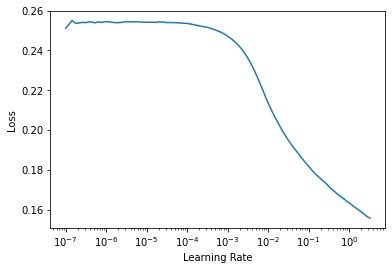

In [ ]:
l.lr_find()

Now we train!

`fit_one_cycle` uses the 1cycle policy proposed by [Smith and Topin (2017)](https://arxiv.org/abs/1708.07120). It's basically a training, where the learning rate increases until it reaches `lr_max` and then it decreases. The momentum does the opposite. Check out the [documentation](https://docs.fast.ai/callback.schedule#Learner.fit_one_cycle) for more details.

In [ ]:
l.fit_one_cycle(10,lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.018236,0.016336,00:42
1,0.009801,0.009679,00:42
2,0.008643,0.009191,00:42
3,0.007818,0.007774,00:42
4,0.007161,0.007132,00:42
5,0.006956,0.006896,00:42
6,0.006797,0.007023,00:42
7,0.006638,0.006642,00:42
8,0.006591,0.006579,00:42
9,0.006548,0.006541,00:42


We can save the model.

In [ ]:
l.path = Path('')

l.save('models/01_cnn_ep10')

## Results

Let's check the predictions of the model.

In [ ]:
preds, targets, losses = l.get_preds(with_loss=True)

On the left we have the predictions and on the right the targets.

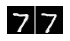

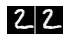

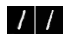

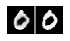

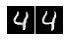

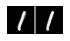

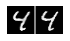

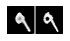

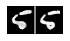

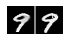

In [ ]:
for i in range(0,10):
  show_image(torch.cat([preds, torch.ones(preds.shape[0],1,28,1), targets], dim=3)[i], cmap='Greys_r')

It looks good, let's now check the predictions that had the top losses.

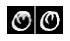

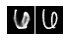

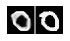

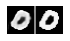

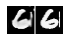

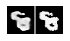

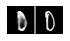

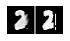

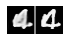

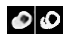

In [ ]:
_, indices = torch.sort(losses, descending=True)

for i in indices[:10]:
  show_image(torch.cat([preds, torch.ones(preds.shape[0],1,28,1), targets], dim=3)[i], cmap='Greys_r')

It looks good as well. Now, we check the lowest losses.

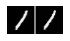

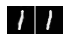

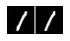

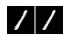

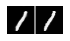

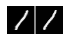

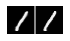

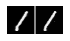

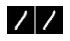

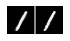

In [ ]:
for i in indices[-10:]:
  show_image(torch.cat([preds, torch.ones(preds.shape[0],1,28,1), targets], dim=3)[i], cmap='Greys_r')

Okay, it seems like our model is doing a good job. 

[Lejeune (2020)](https://doi.org/10.1016/j.eml.2020.100659) also made a model for the same task. She evaluated her model using the mean and the standard deviation of the absolute error of the test set (which is our validation set). She constructed a simple FNN with scikit-learn and obtained a mean equals to 13 and a standard deviation equals to 79, in pixel values.

Let's calculate this metrics for our model.

In [ ]:
px_preds = ((preds*100)-1)*(255/99)
px_targets = ((targets*100)-1)*(255/99)

px_error = torch.abs(px_preds - px_targets)

px_mean = torch.mean(px_error)
px_std = torch.std(px_error)

px_mean, px_std

(tensor(8.5147), tensor(19.0121))

Nice! A mean equals to 8.5 and a standard deviation equals to 19, better than the FNN!

Now let's try to make the data more real. In the next notebook, we're going to add some noise to the displacement field and try beating the model we have just made.